In [1]:
import os
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score
from gensim.models import KeyedVectors
# from albert import *
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, cohen_kappa_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

/home/salsabila.pranida/.conda/envs/ai_aes/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [3]:
# Constants
BASE_DIR = '../'  # Navigate one level up to access directories outside of albert_ira
DATASET_DIR = os.path.join(BASE_DIR, 'dataset')
SAVE_DIR = os.path.join(BASE_DIR, 'result')
MODEL_NAME = "albert-base-v2"
GLOVE_PATH = os.path.join(BASE_DIR, 'word_embeddings/glove.6B.300d.txt')
FASTTEXT_PATH = os.path.join(BASE_DIR, 'word_embeddings/wiki.en.vec')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
albert_model = AutoModel.from_pretrained(MODEL_NAME).to(device)

directories = [BASE_DIR, DATASET_DIR, SAVE_DIR, os.path.dirname(GLOVE_PATH), os.path.dirname(FASTTEXT_PATH)]

for directory in directories:
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Directory created: {directory}")
    else:
        print(f"Directory already exists: {directory}")

2024-11-15 08:59:14.422234: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731646754.435479 3895635 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731646754.439611 3895635 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-15 08:59:14.452782: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Directory already exists: ../
Directory already exists: ../dataset
Directory already exists: ../result
Directory already exists: ../word_embeddings
Directory already exists: ../word_embeddings


In [4]:
def load_glove_model(glove_file_path):
    """Load GloVe embeddings from file into a dictionary."""
    embedding_dict = {}
    with open(glove_file_path, 'r', encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = torch.tensor(np.asarray(values[1:], dtype='float32'))
            embedding_dict[word] = vector.to(device)  # Move to device if necessary
    return embedding_dict

def load_fasttext_model(fasttext_file_path):
    """Load FastText embeddings from file into a dictionary."""
    model = KeyedVectors.load_word2vec_format(fasttext_file_path, binary=False)
    return {word: torch.tensor(model[word]).to(device) for word in model.index_to_key}

# Load embeddings
glove_model = load_glove_model(GLOVE_PATH)
fasttext_model = load_fasttext_model(FASTTEXT_PATH)

In [5]:
# Load and preprocess the dataset
df = pd.read_csv('processed_essay_dataset.csv', sep=',', encoding='ISO-8859-1')
df = df.dropna(subset=['content'])  # Drop rows where 'content' is NaN
df.fillna(0, inplace=True)

# Compute quantiles for content to categorize into quality labels
q1, q3 = df['content'].quantile([0.25, 0.75])
df['quality_label'] = pd.cut(df['content'], bins=[-1, q1, q3, df['content'].max()], labels=[0, 1, 2]).astype(int)
df['quality_label'] = df['quality_label'].map({0: 0, 1: 1, 2: 2})

# Map essay types as before
df['essay_type'] = df['essay_type'].map({'argumentative': 0, 'dependent': 1, 'narrative': 2})
df = df[df['essay_type'].isin([0, 1])]

# Check the result
print(df[['content', 'quality_label', 'essay_type']].head())

   content  quality_label  essay_type
0      4.0              1           0
1      4.0              1           0
2      3.0              1           0
3      5.0              2           0
4      4.0              1           0


In [6]:
# Check the content of the 'content' score column, if it exists
if 'content' in df.columns:
    content_scores = df['content'].describe()
else:
    content_scores = "Column 'content' does not exist in the dataset."

content_scores

count    8876.000000
mean        2.306106
std         1.454485
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         6.000000
Name: content, dtype: float64

In [7]:
class MultiTaskModel(nn.Module):
    """A multitask model for predicting both regression (score) and classification (quality)."""
    def __init__(self, input_shape):
        super(MultiTaskModel, self).__init__()
        # Shared layers
        self.fc1 = nn.Linear(input_shape, 256)
        self.bn1 = nn.BatchNorm1d(256)  # Batch normalization
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.5)
        
        self.regression_head = nn.Linear(128, 1)
        # self.classification_head = nn.Linear(128, 3)  # 3 classes: low, medium, high
        # self.essay_type_head = nn.Linear(128, 3)  # 3 types: argumentative, dependent, narrative

        self.task_uncertainty = nn.Parameter(torch.tensor([0.0, 0.0]), requires_grad=True)
     
    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        
        score_output = self.regression_head(x)
        # quality_output = self.classification_head(x)
        # essay_type_output = self.essay_type_head(x)
        return score_output
            # , quality_output, essay_type_output

    def compute_uncertainty_loss(self, loss_score):
        precision1 = torch.exp(-self.task_uncertainty[0])
        precision2 = torch.exp(-self.task_uncertainty[1])
        
        loss = (precision1 * loss_score + self.task_uncertainty[0]) 
            #    (precision2 * loss_quality + self.task_uncertainty[1])
        
        return loss

    def compute_loss(self, pred_score, y_score):
        mse_loss = nn.MSELoss()(pred_score, y_score)
        # cross_entropy_loss_quality = nn.CrossEntropyLoss()(pred_quality, y_quality)
        # cross_entropy_loss_essay_type = nn.CrossEntropyLoss()(pred_essay_type, y_essay_type)
        
        return mse_loss 
            # + cross_entropy_loss_quality + cross_entropy_loss_essay_type


class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.smoothing = smoothing

    def forward(self, pred, target):
        log_probs = F.log_softmax(pred, dim=-1)
        nll_loss = -log_probs.gather(dim=-1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -log_probs.mean(dim=-1)
        return (1 - self.smoothing) * nll_loss + self.smoothing * smooth_loss

In [8]:
def get_albert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=256).to(device)
    with torch.no_grad():
        outputs = albert_model(**inputs)
    return outputs.last_hidden_state[:, 0, :].cpu().numpy()

def get_word_embedding(text, embedding_dict):
    words = text.lower().split()
    vectors = [embedding_dict[word] for word in words if word in embedding_dict]
    if vectors:
        return torch.mean(torch.stack(vectors), dim=0).cpu().numpy()
    return np.zeros(300)

# Create attention-based embedding fusion
def create_attention_based_embedding(albert_emb, additional_emb):
    if albert_emb.shape != additional_emb.shape:
        additional_emb = torch.nn.Linear(additional_emb.shape[0], albert_emb.shape[0]).to(albert_emb.device)(additional_emb)
    combined_emb = torch.cat([albert_emb.unsqueeze(0), additional_emb.unsqueeze(0)], dim=0)
    attention_weights = torch.nn.Parameter(torch.tensor([0.5, 0.5], device=albert_emb.device), requires_grad=True)
    attention_scores = F.softmax(attention_weights, dim=0)
    fused_embedding = attention_scores[0] * albert_emb + attention_scores[1] * additional_emb
    return fused_embedding

def create_combined_embedding(text, embedding_type=None, _glove_model=None, _fasttext_model=None):
    albert_emb = get_albert_embedding(text).flatten()

    if embedding_type == "glove":
        additional_emb = get_word_embedding(text, _glove_model)
    elif embedding_type == "fasttext":
        additional_emb = get_word_embedding(text, _fasttext_model)
    else:
        additional_emb = np.array([])

    albert_emb_tensor = torch.tensor(albert_emb, dtype=torch.float32).to(device)

    if additional_emb.size != 0:
        additional_emb_tensor = torch.tensor(additional_emb, dtype=torch.float32).to(device)
        
        # Ensure both embeddings have the same size by truncating or padding
        if additional_emb_tensor.size(0) > albert_emb_tensor.size(0):
            additional_emb_tensor = additional_emb_tensor[:albert_emb_tensor.size(0)]  # Truncate
        elif additional_emb_tensor.size(0) < albert_emb_tensor.size(0):
            padding_size = albert_emb_tensor.size(0) - additional_emb_tensor.size(0)
            additional_emb_tensor = F.pad(additional_emb_tensor, (0, padding_size))  # Pad with zeros

        combined_emb = torch.cat([albert_emb_tensor, additional_emb_tensor], dim=0)
    else:
        combined_emb = albert_emb_tensor

    return combined_emb.cpu().numpy(), combined_emb.size(0)


In [9]:
def train_and_save_model(X_train_tensor, y_train_tensor, input_shape, save_dir, epochs=10, batch_size=8, learning_rate=1e-4):
    model = MultiTaskModel(input_shape).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)

    train_losses = []  # Track training loss per epoch
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for X_batch, y_score_batch in train_loader:
            X_batch, y_score_batch = X_batch.to(device), y_score_batch.to(device)
            optimizer.zero_grad()
            pred_score = model(X_batch)

            mse_loss = nn.MSELoss()(pred_score, y_score_batch).mean()  # Ensure it's a scalar
            mse_loss.backward()
            optimizer.step()
            epoch_loss += mse_loss.item()

        avg_epoch_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_epoch_loss)
        print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {avg_epoch_loss:.4f}")

    model_filename = f"albert4_model_{embedding_type or 'albert'}.pth"
    embedding_size_filename = f"albert4_embedding_size_{embedding_type or 'albert'}.npy"
    torch.save(model.state_dict(), os.path.join(save_dir, model_filename))
    np.save(os.path.join(save_dir, embedding_size_filename), input_shape)
    
    return os.path.join(save_dir, model_filename), train_losses  # Return train_losses

In [10]:
def evaluate_model(model_path, X_test_tensor, y_test, save_dir):
    model = MultiTaskModel(X_test_tensor.shape[1]).to(device)  # Move model to device
    model.load_state_dict(torch.load(model_path))
    model.eval()

    X_test_tensor = X_test_tensor.to(device)

    with torch.no_grad():
        pred_scores = model(X_test_tensor)
        pred_scores_np = pred_scores.cpu().numpy().squeeze()
        mse = mean_squared_error(y_test, pred_scores_np)

        y_test_rounded = np.round(y_test).astype(int)  # Round y_test to nearest integer for classification metrics
        pred_scores_rounded = np.round(pred_scores_np).astype(int)  # Round predicted scores

        f1_scores = f1_score(y_test_rounded, pred_scores_rounded, average='weighted')
        accuracy_scores = accuracy_score(y_test_rounded, pred_scores_rounded)
        kappa_scores = cohen_kappa_score(y_test_rounded, pred_scores_rounded, weights='quadratic')

    # Print out the evaluation results
    print(f"Evaluation Results:\nMSE: {mse:.5f}")
    print(f"Accuracy: {accuracy_scores:.5f}")
    print(f"F1 Score: {f1_scores:.5f}")
    print(f"Quadratic Kappa: {kappa_scores:.5f}")

    plot_confusion_matrices(y_test_rounded, pred_scores_rounded)

    return mse, accuracy_scores, f1_scores, kappa_scores

def plot_confusion_matrices(y_test, y_pred):
    fig, ax = plt.subplots(figsize=(7, 7))
    
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm).plot(ax=ax, cmap='Blues', values_format='d')
    ax.set_title("Confusion Matrix for Rounded Regression Output")
    
    plt.show()

def plot_training_history(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.show()


Training model for embedding type: albert
Epoch 1/10, Training Loss: 1.2516
Epoch 2/10, Training Loss: 0.9376
Epoch 3/10, Training Loss: 0.9338
Epoch 4/10, Training Loss: 0.8998
Epoch 5/10, Training Loss: 0.8338
Epoch 6/10, Training Loss: 0.8330
Epoch 7/10, Training Loss: 0.8390
Epoch 8/10, Training Loss: 0.7723
Epoch 9/10, Training Loss: 0.7848
Epoch 10/10, Training Loss: 0.7640

Evaluating model for embedding type: albert
Evaluation Results:
MSE: 0.52354
Accuracy: 0.51577
F1 Score: 0.50008
Quadratic Kappa: 0.83343


/tmp/slurm-salsabila.pranida-51373/ipykernel_2176047/1723249264.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


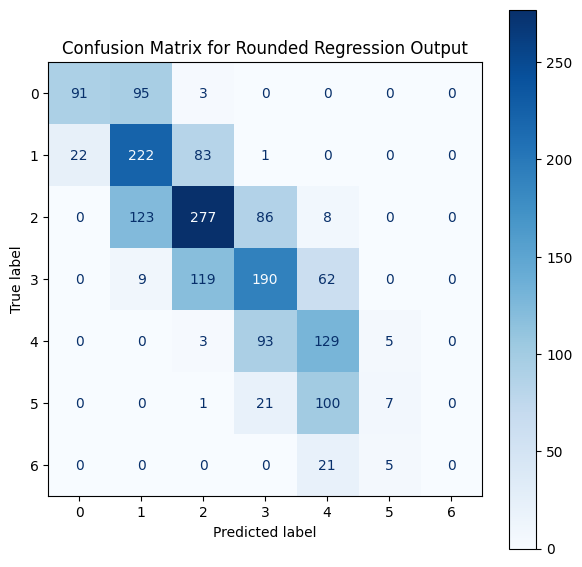


Training model for embedding type: glove
Epoch 1/10, Training Loss: 1.2163
Epoch 2/10, Training Loss: 0.9913
Epoch 3/10, Training Loss: 0.9270
Epoch 4/10, Training Loss: 0.8879
Epoch 5/10, Training Loss: 0.8316
Epoch 6/10, Training Loss: 0.8136
Epoch 7/10, Training Loss: 0.8471
Epoch 8/10, Training Loss: 0.7987
Epoch 9/10, Training Loss: 0.7777
Epoch 10/10, Training Loss: 0.7775

Evaluating model for embedding type: glove
Evaluation Results:
MSE: 0.50241
Accuracy: 0.51914
F1 Score: 0.50427
Quadratic Kappa: 0.84384


/tmp/slurm-salsabila.pranida-51373/ipykernel_2176047/1723249264.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


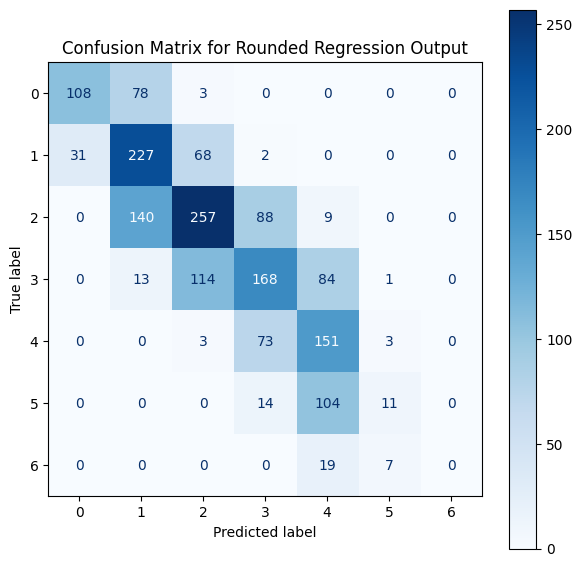


Training model for embedding type: fasttext
Epoch 1/10, Training Loss: 1.2606
Epoch 2/10, Training Loss: 0.9766
Epoch 3/10, Training Loss: 0.9270
Epoch 4/10, Training Loss: 0.9172
Epoch 5/10, Training Loss: 0.8563
Epoch 6/10, Training Loss: 0.8560
Epoch 7/10, Training Loss: 0.8131
Epoch 8/10, Training Loss: 0.8150
Epoch 9/10, Training Loss: 0.7738
Epoch 10/10, Training Loss: 0.7879

Evaluating model for embedding type: fasttext
Evaluation Results:
MSE: 0.55710
Accuracy: 0.51745
F1 Score: 0.49631
Quadratic Kappa: 0.82825


/tmp/slurm-salsabila.pranida-51373/ipykernel_2176047/1723249264.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


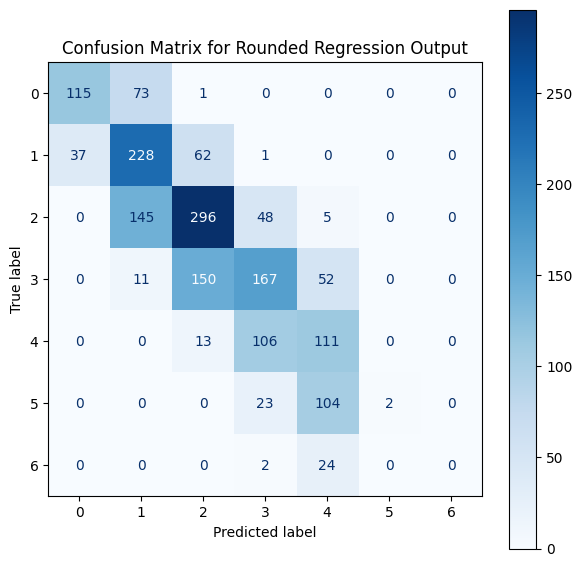

In [14]:
# Main training and evaluation loop
embedding_types = [None, "glove", "fasttext"]
all_train_losses = []  # To store training losses for each embedding type
embedding_labels = [embedding_type or 'albert' for embedding_type in embedding_types]

for embedding_type in embedding_types:
    embeddings_and_sizes = df['essay'].apply(lambda x: create_combined_embedding(x, embedding_type, glove_model, fasttext_model))
    df['embeddings'], embedding_sizes = zip(*embeddings_and_sizes)

    embedding_sizes = np.array(embedding_sizes)

    X_train, X_test, y_train, y_test = train_test_split(
        np.stack(df['embeddings'].values), 
        df['content'].values, 
        test_size=0.2, random_state=42
    )

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

    print(f"\nTraining model for embedding type: {embedding_type or 'albert'}")
    model_path, train_losses = train_and_save_model(
        X_train_tensor, y_train_tensor, 
        X_train_tensor.shape[1], SAVE_DIR, epochs=10, batch_size=8, learning_rate=1e-3
    )

    all_train_losses.append(train_losses)  # Store train losses for plotting

    print(f"\nEvaluating model for embedding type: {embedding_type or 'albert'}")
    evaluate_model(model_path, X_test_tensor, y_test_tensor.squeeze().numpy(), SAVE_DIR)

# # Plot training history for all embedding types
# plot_training_history(all_train_losses, embedding_labels)

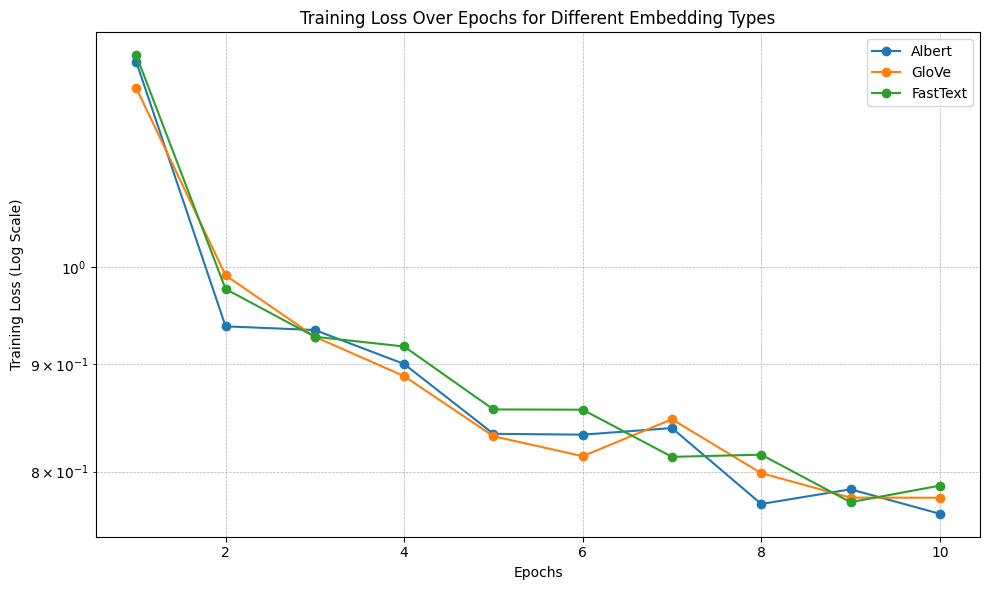

In [15]:
import matplotlib.pyplot as plt

# Labels for the embeddings
embedding_labels = ['Albert', 'GloVe', 'FastText']

# Plotting the training loss curves
plt.figure(figsize=(10, 6))
epochs = range(1, 11)

# Plot each embedding type with markers and a logarithmic y-scale
for losses, label in zip(all_train_losses, embedding_labels):
    plt.plot(epochs, losses, label=label, marker='o')

# Set the y-axis to logarithmic scale to show smaller differences
plt.yscale('log')

# Add labels, title, and grid for better readability
plt.xlabel('Epochs')
plt.ylabel('Training Loss (Log Scale)')
plt.title('Training Loss Over Epochs for Different Embedding Types')
plt.legend()
plt.grid(True, which="both", linestyle='--', linewidth=0.5)  # Add grid for readability
plt.tight_layout()  # Adjust layout for better fitting
plt.show()

In [11]:
content = """
    In “Let there be dark,” Paul Bogard talks about the importance of darkness.
Darkness is essential to humans. Bogard states, “Our bodies need darkness to produce the hormone melatonin, which keeps certain cancers from developing, and our bodies need darkness for sleep, sleep. Sleep disorders have been linked to diabetes, obesity, cardiovascular disease and depression and recent research suggests are main cause of “short sleep” is “long light.” Whether we work at night or simply take our tablets, notebooks and smartphones to bed, there isn’t a place for this much artificial light in our lives.” (Bogard 2). Here, Bogard talks about the importance of darkness to humans. Humans need darkness to sleep in order to be healthy.
Animals also need darkness. Bogard states, “The rest of the world depends on darkness as well, including nocturnal and crepuscular species of birds, insects, mammals, fish and reptiles. Some examples are well known—the 400 species of birds that migrate at night in North America, the sea turtles that come ashore to lay their eggs—and some are not, such as the bats that save American farmers billions in pest control and the moths that pollinate 80% of the world’s flora. Ecological light pollution is like the bulldozer of the night, wrecking habitat and disrupting ecosystems several billion years in the making. Simply put, without darkness, Earth’s ecology would collapse...” (Bogard 2). Here Bogard explains that animals, too, need darkness to survive.
""" 

In [12]:
def testContent(content, embedding_type=None, SAVE_DIR=None, glove_model=None, fasttext_model=None, min_score=0, max_score=100):
    # Generate the combined embedding
    embedding, actual_embedding_size = create_combined_embedding(
        content,
        embedding_type=embedding_type,
        _glove_model=glove_model if embedding_type == "glove" else None,
        _fasttext_model=fasttext_model if embedding_type == "fasttext" else None
    )

    embedding_tensor = torch.tensor(embedding, dtype=torch.float32).to(device).unsqueeze(0)

    # Load model files
    embedding_size_filename = f"albert4_embedding_size_{embedding_type or 'albert'}.npy"
    model_filename = f"albert4_model_{embedding_type or 'albert'}.pth"
    
    # Load the expected embedding size and model
    embedding_size_path = os.path.join(SAVE_DIR, embedding_size_filename)
    expected_embedding_size = int(np.load(embedding_size_path))

    # Initialize model and load weights
    model = MultiTaskModel(expected_embedding_size).to(device)
    model_path = os.path.join(SAVE_DIR, model_filename)
    state_dict = torch.load(model_path, map_location=device)
    filtered_state_dict = {k: v for k, v in state_dict.items() if k in model.state_dict()}
    model.load_state_dict(filtered_state_dict, strict=False)
    model.eval()

    # Adjust embedding size if necessary
    embedding_resized = embedding_tensor[:, :expected_embedding_size]

    # Make predictions
    with torch.no_grad():
        pred_score = model(embedding_resized)

    # Extract and normalize the score
    raw_score = pred_score[0].cpu().item()
    normalized_score = max(0, min(100, (raw_score - min_score) / (max_score - min_score) * 100))

    return round(normalized_score, 2)


In [13]:
embedding_types = [None, "glove", "fasttext"]

results = {}

for embedding_type in embedding_types:
    embedding_type_name = {
        None: "ALBERT",
        "glove": "ALBERT + GloVe",
        "fasttext": "ALBERT + FastText"
    }[embedding_type]

    # Get the score for the current embedding type
    score = testContent(
        content=content,
        embedding_type=embedding_type,
        SAVE_DIR=SAVE_DIR,
        glove_model=glove_model,
        fasttext_model=fasttext_model
    )

    results[embedding_type_name] = score

# Display results
for embedding_name, score in results.items():
    print(f"{embedding_name}: {score:.2f}")

/tmp/slurm-salsabila.pranida-51449/ipykernel_3895635/2175783135.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)

ALBERT: 4.37
ALBERT + GloVe: 4.10
ALBERT + FastText: 3.79
